In [1]:
import csv

import pandas as pd
import numpy as np
from xgboost import XGBRegressor

ROUND = "221"
TOURNAMENT_NAME = "kazutsugi"
TARGET_NAME = f"target_{TOURNAMENT_NAME}"
PREDICTION_NAME = f"prediction_{TOURNAMENT_NAME}"

/home/tarai/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Submissions are scored by spearman correlation
def score(df):
    # method="first" breaks ties based on order in array
    pct_ranks = df[PREDICTION_NAME].rank(pct=True, method="first")
    targets = df[TARGET_NAME]
    return np.corrcoef(targets, pct_ranks)[0, 1]


# Payout is just the score cliped at +/-25%
def payout(scores):
    return scores.clip(lower=-0.25, upper=0.25)

In [4]:
# Load Data
training_data = pd.read_hdf(f"../../dataset/numerai_dataset_{ROUND}/numerai_training_data.hdf").set_index("id")
tournament_data = pd.read_hdf(f"../../dataset/numerai_dataset_{ROUND}/numerai_tournament_data.hdf").set_index("id")

In [5]:
# Sample submission file
sample_predict = pd.read_csv(f"../../dataset/numerai_dataset_{ROUND}/example_predictions_target_kazutsugi.csv").set_index("id")

In [6]:
sample_predict.head(1)

,prediction_kazutsugi
id,
n0003aa52cab36c2,0.48416


In [7]:
feature_names = [
    f for f in training_data.columns if f.startswith("feature")
]
print(f"Loaded {len(feature_names)} features")

print("Training model...")
# This is the model that generates the included example predictions file
# Taking too long? Set learning_rate=0.1 and n_estimators=200 to make this run faster
# model = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)
# model.fit(training_data[feature_names], training_data[TARGET_NAME])

# Generate predictions on both training and tournament data
print("Generating predictions...")
# training_data[PREDICTION_NAME] = model.predict(training_data[feature_names])
# tournament_data[PREDICTION_NAME] = model.predict(tournament_data[feature_names])
# training_data[PREDICTION_NAME] = training_data.join(sample_predict)[PREDICTION_NAME]
tournament_data[PREDICTION_NAME] = tournament_data.join(sample_predict)[PREDICTION_NAME]

# Check the per-era correlations on the training set (in sample)
# train_correlations = training_data.groupby("era").apply(score)
# print(f"On training the correlation has mean {train_correlations.mean()} and std {train_correlations.std()}")
# print(f"On training the average per-era payout is {payout(train_correlations).mean()}")

# Check the per-era correlations on the validation set (out of sample)
validation_data = tournament_data[tournament_data.data_type == "validation"]
validation_correlations = validation_data.groupby("era").apply(score)
print(f"On validation the correlation has mean {validation_correlations.mean()} and std {validation_correlations.std()}")
print(f"On validation the average per-era payout is {payout(validation_correlations).mean()}")

Loaded 310 features
Training model...
Generating predictions...
On validation the correlation has mean 0.02887754008290889 and std 0.030828106914912855
On validation the average per-era payout is 0.02887754008290889


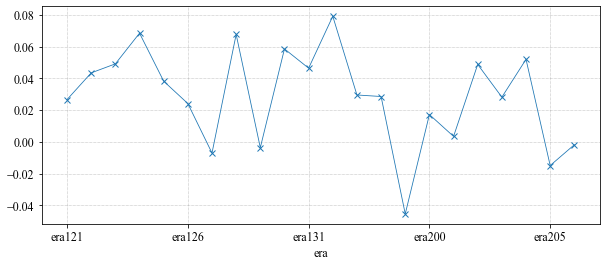

In [12]:
validation_correlations.plot(figsize=(10,4), marker="x")